In [28]:
from geopy.geocoders import Nominatim
import tqdm
import pandas as pd
import time
import cloudscraper
from bs4 import BeautifulSoup
import geopandas as gpd
import numpy as np
import json
import h3
import folium
import osmnx as ox
from shapely import wkt
from folium.plugins import HeatMap
from shapely.geometry import Polygon
import warnings
import re
from shapely.wkt import loads
from shapely.geometry import Point, Polygon
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import requests
import random

warnings.simplefilter(action='ignore', category=FutureWarning)

# PARSING AND EDA

### Для начала запарсим какое то количество ссылок с квартирами.

Есть библиотечка, которая неплохо справляется с этим, но там ограничение на 54 странницы. Поэтому мы достали из OSM названия станций метро, чуть чуть пошаманили и парсили квартиры для каждой станции метро:

In [ ]:
import cianparser

In [ ]:
# stations = pd.read_csv('metro_stations.csv')
# metro = stations['station_name'].drop_duplicates().to_list()
# parser_metro = cianparser.list_metro_stations()['Московский']
# parser_metro = [item for sublist in parser_metro for item in sublist]
# parser_metro = [item for item in parser_metro if not any(char.isdigit() for char in item)]
# for el in metro:
#     if el not in parser_metro:
#         print(el)
# metro = [x for x in metro if x != 'Москва-Рижская']
# metro.append('Рижская')
# metro = [x for x in metro if x != 'Кузнецкий Мост']
# metro.append('Кузнецкий мост')
# metro = [x for x in metro if x != 'Достоевская']
# metro = [x for x in metro if x != 'Москва-Пассажирская-Смоленская']
# metro.append('Смоленская')
# metro = [x for x in metro if x != 'Автостанция «ВДНХ»']
# metro.append('ВДНХ')
# print('-------')
# for el in metro:
#     if el not in parser_metro:
#         print(el)

Вот соответственно само тело парсинга

In [ ]:
# all_data = []

# for station_metro in tqdm(metro[::-1], desc="Processing Metro Stations"):
#     additional_settings = {
#         "start_page": 1,
#         "end_page": 25,
#         "metro": "Московский",
#         "metro_station": station_metro,
#         "only_flat": True,
#         "sort_by": "creation_data_from_newer_to_older",
#     }

#     moscow_parser = cianparser.CianParser(location="Москва")
#     data = moscow_parser.get_flats(deal_type="sale", rooms='all', additional_settings=additional_settings)
#     all_data.extend(data)

# cian = pd.DataFrame(all_data)

# cian.to_csv('cian_data_25_metro.csv', index=False)

In [71]:
df = pd.read_csv('cian_data_25_metro.csv')

In [72]:
df.shape

(5369, 18)

In [73]:
df.head()

,author,author_type,url,location,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,price_per_month,commissions,price,district,street,house_number,underground,residential_complex
0,ID 116395985,homeowner,https://korolev.cian.ru/sale/flat/301849489/,Москва,sale,flat,2,5,2,44.3,-1,0,6700000,NaN,К.Д. Трофимова,4,ВДНХ,NaN
1,ID 116394116,realtor,https://www.cian.ru/sale/flat/301847601/,Москва,sale,flat,15,21,3,107.0,-1,0,46000000,Алексеевский,Новоалексеевская,16к2,ВДНХ,Серебряный фонтан
2,Евгения Якина,realtor,https://korolev.cian.ru/sale/flat/301839032/,Москва,sale,flat,2,5,1,32.0,-1,0,5600000,NaN,К.Д. Трофимова,8,ВДНХ,NaN
3,ID 683817,homeowner,https://mytishchi.cian.ru/sale/flat/301838656/,Москва,sale,flat,3,9,2,43.0,-1,0,8000000,NaN,3-я Парковая,21,ВДНХ,NaN
4,Тёплый Дом,real_estate_agent,https://korolev.cian.ru/sale/flat/301838441/,Москва,sale,flat,14,16,-1,25.3,-1,0,5999000,NaN,Марины Цветаевой,1Б,ВДНХ,NaN


### К ссылкам запарсим всякие фичи: 

1. Словарь со всеми ближайшими станциями метро и расстояниями до них
2. Размещено ли объявление застройщиком или физ.лицом (читайте, действует ли льготная ипотека)
3. История цены объекта
4. Санузел
5. Тип дома (панельный, кирпичный и тд)
6. Вид из окон
7. Отделка

In [2]:
desktop_user_agents = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:95.0) Gecko/20100101 Firefox/95.0',
]

def get_desktop_user_agent():
    return random.choice(desktop_user_agents)


def get_html(url):
    user_agent = get_desktop_user_agent()
    response = requests.get(url, headers={'User-Agent': user_agent})

    time.sleep(random.uniform(3, 5))
    return response.text


# df['script'] = df['url'].apply(get_html)

def create_soup(html):
    return BeautifulSoup(html, 'html.parser')

# df['bs'] = df['script'].apply(create_soup)


def extract_offer_facts_text(soup):
    try:
        soup = soup
        print(soup)
        description_element = soup.find("div", {"data-name": "Description"})

            
        data = {}
        history_element = soup.find("div", class_=lambda cls: cls and re.search(r'.*history-wrapper*.', cls))
        dates_prices = []
        if history_element:

            dates = history_element.find_all(lambda tag: tag.has_attr('class') and any(re.match(r'.*event-date.*', cls) for cls in tag['class']))
            prices = history_element.find_all(lambda tag: tag.has_attr('class') and any(re.match(r'.*event-price.*', cls) for cls in tag['class']))
            
            if len(dates) == len(prices):
                for date, price in zip(dates, prices):
                        
                        dates_prices.append({date.get_text().strip():price.get_text().strip()})

        

        print('--------------------')
        if description_element:
            description_element = description_element.get_text().strip()
        else:
            description_element = ''
            
        data['description'] = description_element

        data['price_history'] = dates_prices
        price_element = soup.find("div", {"data-name": 'OfferCardPageLayoutAside'})
        
        price_element = soup.find("div", {"data-name": 'OfferCardPageLayoutAside'})
        if price_element:
            price = float(price_element.find(lambda tag: tag.has_attr('class') and any(re.match(r'.*amount.*', cls) for cls in tag['class'])).text.strip().replace('\xa0', '').replace('₽', ''))
        else:
            price = -1

        data['price'] = price

        address_texts = []
        address_container_divs = soup.find_all("div", {"data-name": "AddressContainer"})
        for address_container_div in address_container_divs:
            text_content = address_container_div.get_text(separator=' ').strip()
            text_content = text_content.rstrip("На карте").strip()
            address_texts.extend([address.strip() for address in text_content.split(',') if address.strip()])

        if len(address_texts)>=5:
            if address_texts[4][0:2] == 'вл':
                address_texts[4] = address_texts[4][2:]

        if len(address_texts) == 3:
            result_address = ', '.join(address_texts)
        elif len(address_texts) == 5:
            result_address = ', '.join([address_texts[0], address_texts[3], address_texts[4]])
        elif len(address_texts) == 4:
            result_address = ', '.join([address_texts[0], address_texts[3]])
        else:
            result_address = ''
            
        data['address'] = result_address

        phones_container = soup.find("div", {"data-name": "PhonesContainer"})

        if phones_container:
            contact_flag = phones_container.get_text().strip()
        else:
            contact_flag = "No contact information found"

        if contact_flag == 'Контакты застройщика':
            developer = 1
        else:
            developer = 0
            
        data['developer_flg'] = developer
        params = {}
        params_keys = []
        params_values = []
        if len(soup.find_all("table")) >0:
            for tab in soup.find_all("table")[:1]:
                for key, elem in enumerate(tab.find_all('td')):
                    if key%2 == 0:
                        params_keys.append(elem.text)
                    else:
                        params_values.append(elem.text)
                    
                params = dict(zip(params_keys, params_values))

        data['params'] = params
        if soup.find_all('ul', {'data-name': True}):
            div_elements = soup.find_all('ul', {'data-name': True})
            data_by_name = {}

            for div_element in div_elements:
                data_name = div_element.get('data-name')
                text_content = div_element.get_text(separator=' ')
                data_by_name[data_name] = text_content.strip()
            metro_stations = {}
            if 'UndergroundList' in data_by_name.keys():
                underground_items = div_elements[1].find_all("li", {"data-name": 'UndergroundItem'})
                true_soup = []
                for elem in underground_items:
                    if 'm14 7-.84-4.196A1 1 0 0 0 12.18 ' not in str(elem):
                        true_soup.append(elem)
                for el in true_soup:
                    metro_station = el.find("a", {"class": True}).text
                
                    try:
                        t = (int(el.text.replace(str(metro_station), '').split()[0]))
                    except:
                        t = el.text.replace(str(metro_station), '').split()[0]
                    metro_stations[metro_station] = t
        else:
            metro_stations = {}
                
        data['metro'] = metro_stations

        return data
    except:
        return None

    

# df['d'] = df['bs'].apply(lambda link: extract_offer_facts_text(link))

### Теперь feature engineering с координатами

#### Функции для визуализации

In [74]:
def visualize_polygons(geometries):
    m = folium.Map(location=[55, 37], zoom_start=13, tiles='cartodbpositron')
    for geometry in geometries:
        overlay = gpd.GeoSeries(geometry).to_json()
        folium.GeoJson(overlay, name = 'boundary').add_to(m)
        
    return m
def visualize_points_on_map(gdf, point_column='geometry_point', zoom_start=10):
    m = folium.Map(location=[gdf[point_column].iloc[0].y, gdf[point_column].iloc[0].x], zoom_start=zoom_start)
    for index, row in gdf.iterrows():
        point = row[point_column]
        folium.CircleMarker(location=[point.y, point.x], radius=3, color='blue', fill=True, fill_color='blue', fill_opacity=0.7, popup=str(index)).add_to(m)
    return m

#### здесь мы получаем координаты из адреса. Это самый адекватный класс который я нашел, но там куча проблем и отсюда куча ифов :). Но оно перестало почему то работать и больше чем для 165 строк не получается ничего сделать, сделаем то следующего дедлайна, сейчас эта часть не рабочая :(

In [75]:
df['adress'] = 'Москва, ' + df['street'].str.strip() + ', ' + df['house_number'].str.strip()

In [76]:
def address_to_coordinates(address, name_app):
    geolocator = Nominatim(user_agent=name_app)
    location = geolocator.geocode(address)

    if location:
        latitude, longitude = location.latitude, location.longitude
        return longitude, latitude
    else:
        if len(address.split(',')) != 3:
            # print(f'{address}')
            return None
        else:
            city, street, house = address.split(',')
            city = city.strip()
            street = street.strip()
            house = house.strip()
            indexes = [house.find('/'), house.find('С'), house.find('С'), house.find('К'), house.find('к'), house.find('/'), house.find('A'), house.find('Б'), house.find('В'), house.find('а')]
            index = [num for num in indexes if num > 0]
            if index:
                index = min(index)
                house = house[:index]
            street = street.replace("переулок", "")
            street = street.split(' ')
            street = ' '.join(street)
            new_adress = city + ', ' + street.strip() + ', ' + house.strip()
            location = geolocator.geocode(new_adress)
            if location:
                latitude, longitude = location.latitude, location.longitude
                # print(f'было: {address} нашлось для: {new_adress}')
                return longitude, latitude
            else:
                new_adress = city + ', ' + street.strip() + ', ' + '9'
                location = geolocator.geocode(new_adress)
                if location:
                    latitude, longitude = location.latitude, location.longitude
                    # print(f'было: {address} нашлось для: {new_adress}')
                    return longitude, latitude
                else:
                    # print(f"COORDS NOT FOUND found for address: {address} and {new_adress}")
                    return None

In [3]:
# df = df[~df['coords'].isna() & df['coords'] != 'Not Found' & df['coords'] != ' ']
# df['coords'] = df['coords'].progress_apply(lambda x: Point(x))
# df.to_csv('cian_data.csv', index=False)

### просто визуализация квартир на карте

In [183]:
df['geometry_point'] = df['coords']
visualize_points_on_map(df)

Также достанем из OSM границы райнов Москвы, когда нормально научимся пользоваться геокодером, то сделае фичу категориальную :)

In [327]:
cities = ['Москва']
polygon_msc = ox.features_from_place(cities, {'boundary':'administrative', }).reset_index()
polygon_msc = polygon_msc.dropna(subset=['name'])
condition = polygon_msc['geometry'].apply(lambda geom: isinstance(geom, (Polygon)))
filtered_polygon_msc = polygon_msc[condition]
filtered_polygon_msc = filtered_polygon_msc[filtered_polygon_msc['name'].str.contains('район')]
filtered_polygon_msc_geo = filtered_polygon_msc['geometry'].to_list()
visualize_polygons(filtered_polygon_msc_geo)

In [328]:
filtered_polygon_msc = filtered_polygon_msc[['geometry', 'name']].reset_index().drop(columns='index')

In [329]:
filtered_polygon_msc

,geometry,name
0,"POLYGON ((36.58087 55.05930, 36.58419 55.06144...",Жуковский район
1,"POLYGON ((37.36539 55.77181, 37.36552 55.77190...",район Крылатское
2,"POLYGON ((37.36889 55.77304, 37.36892 55.77394...",район Строгино
3,"POLYGON ((37.33566 55.84525, 37.33300 55.84528...",район Митино
4,"POLYGON ((37.36986 55.90820, 37.37296 55.90964...",район Куркино
...,...,...
115,"POLYGON ((37.74294 55.78772, 37.74295 55.78815...",район Измайлово
116,"POLYGON ((37.79993 55.78827, 37.80027 55.78833...",район Ивановское
117,"POLYGON ((37.62787 55.75952, 37.62804 55.75960...",Басманный район
118,"POLYGON ((37.47628 55.52656, 37.47625 55.52662...",район Южное Бутово


In [331]:
import geopandas as gpd
from shapely.geometry import Point

filtered_polygon_msc = gpd.GeoDataFrame(filtered_polygon_msc, geometry='geometry')

df['geometry_point'] = gpd.GeoSeries(df['geometry_point'].apply(Point))

def find_district(point):
    for idx, row in filtered_polygon_msc.iterrows():
        if row['geometry'].contains(point):
            return row['name']
    return "suburban"

df['district'] = df['geometry_point'].apply(find_district)


/var/folders/16/gvgn76k51z9908w6pgr_j60h4szdym/T/ipykernel_62072/2800759791.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['district'] = df['geometry_point'].apply(find_district)


### Теперь feature engineering с описаниями квартир, NLP!

здесь тоже короче мы это сделали только на сотне обьявлений, а при более масштабном парсинге столкнулись с миллионом проблем ну и на больших данных не делали еще

In [184]:
from pymystem3 import Mystem
import string
from nltk.corpus import stopwords

mystem_analyzer = Mystem()
stop_words_ru = set(stopwords.words('russian'))
translator = str.maketrans('', '', string.punctuation)

def preprocessing_text(text):
    text = text.replace('\n', ' ')
    text_no_punctuation = text.translate(translator)
    lemmatized_text = []
    for word in mystem_analyzer.lemmatize(text_no_punctuation):
        word = word.strip()
        if word and not any(char.isdigit() for char in word) and word not in stop_words_ru:
            lemmatized_text.append(word)
    return lemmatized_text

tqdm.pandas(desc="Decoding")
df['lem_text'] = df['descrpition'].progress_apply(preprocessing_text)

Decoding:   0%|          | 0/93 [00:00<?, ?it/s]

Decoding: 100%|██████████| 93/93 [00:01<00:00, 91.14it/s] 


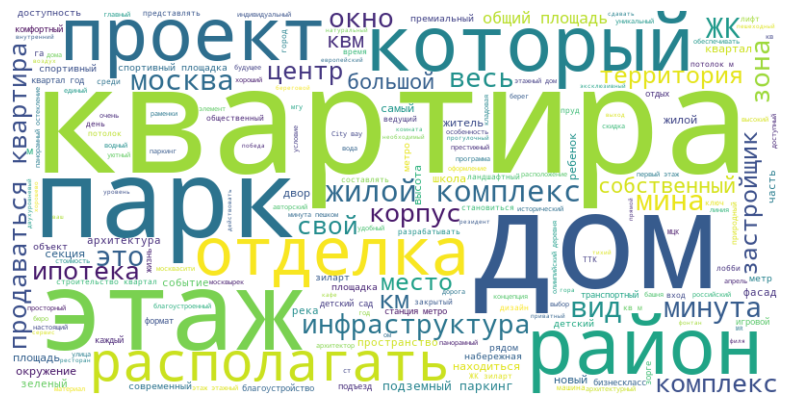

In [185]:
all_words = ' '.join([word for sublist in df.loc[df['developer_flg'] == 1, 'lem_text'] for word in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

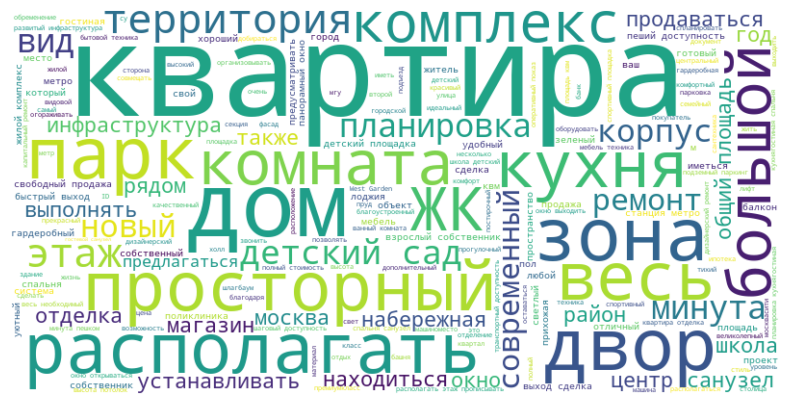

In [186]:
all_words = ' '.join([word for sublist in df.loc[df['developer_flg'] == 0, 'lem_text'] for word in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [206]:
from sklearn.feature_extraction.text import TfidfVectorizer

text_data = df['lem_text'].apply(lambda x: ' '.join(x))
vectorizer = TfidfVectorizer(max_df = 0.55)
tfidf_matrix = vectorizer.fit_transform(text_data)
feature_names = vectorizer.get_feature_names_out()
tfidf_values = tfidf_matrix.sum(axis=0).A1
sorted_indices = tfidf_values.argsort()[::-1]
top_words_indices = sorted_indices[:100]
top_words_tfidf = [(feature_names[i], tfidf_values[i]) for i in top_words_indices]

In [207]:
top_words_tfidf

[('комплекс', 4.029868223764047),
 ('этаж', 3.3155292043359776),
 ('минута', 3.2528165506253788),
 ('весь', 3.226611138867877),
 ('спальня', 3.1682131252038275),
 ('двор', 3.127436011528153),
 ('парк', 3.0853714093088147),
 ('просторный', 2.9460984253323272),
 ('ремонт', 2.9205907257673056),
 ('располагать', 2.9011613216051946),
 ('продажа', 2.8879868959109616),
 ('доступность', 2.8070895085095144),
 ('комната', 2.7742866417205927),
 ('вид', 2.740168866406203),
 ('жк', 2.7236203809644692),
 ('санузел', 2.673662995605984),
 ('зона', 2.63962281596356),
 ('площадка', 2.5839142101901995),
 ('планировка', 2.5806309513893684),
 ('метро', 2.570103584329911),
 ('территория', 2.554350956625117),
 ('большой', 2.5414257303117096),
 ('район', 2.5186277965142176),
 ('собственник', 2.419910935503536),
 ('сад', 2.3974261054891626),
 ('инфраструктура', 2.3928093177355803),
 ('отделка', 2.3803211192030695),
 ('кухня', 2.3802020797769066),
 ('жилой', 2.3250344072103726),
 ('техника', 2.321086607363324),

In [204]:
for word, _ in top_words_tfidf:
    df[word] = df['lem_text'].apply(lambda x: 1 if word in ' '.join(x) else 0)

# анализ чиселок

In [110]:
df = df[df['total_meters'] >= 20]

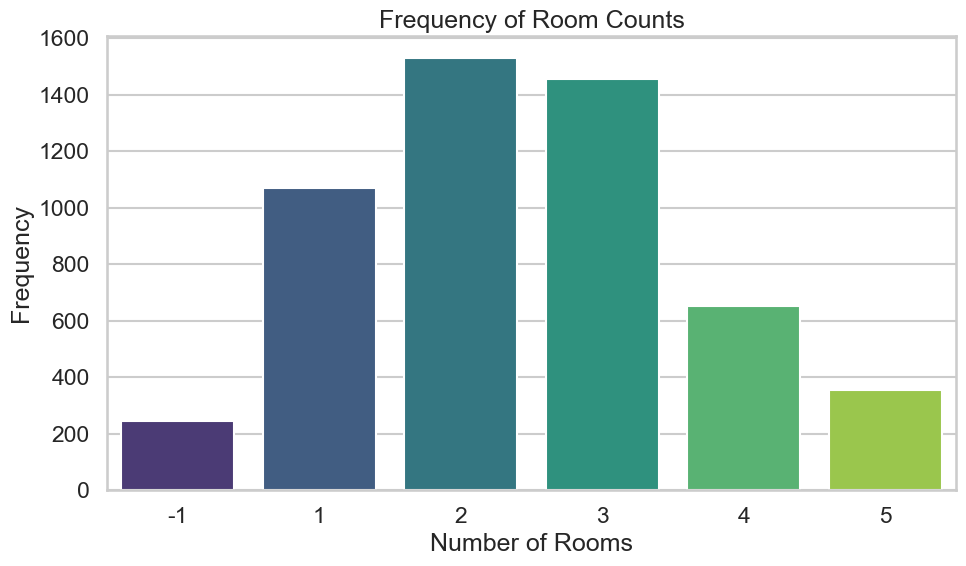

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_context("talk")
room_counts = df['rooms_count'].value_counts().reset_index()
room_counts.columns = ['Rooms', 'Frequency']
plt.figure(figsize=(10, 6))
sns.barplot(data=room_counts, x='Rooms', y='Frequency', palette='viridis')
plt.title('Frequency of Room Counts')
plt.xlabel('Number of Rooms')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

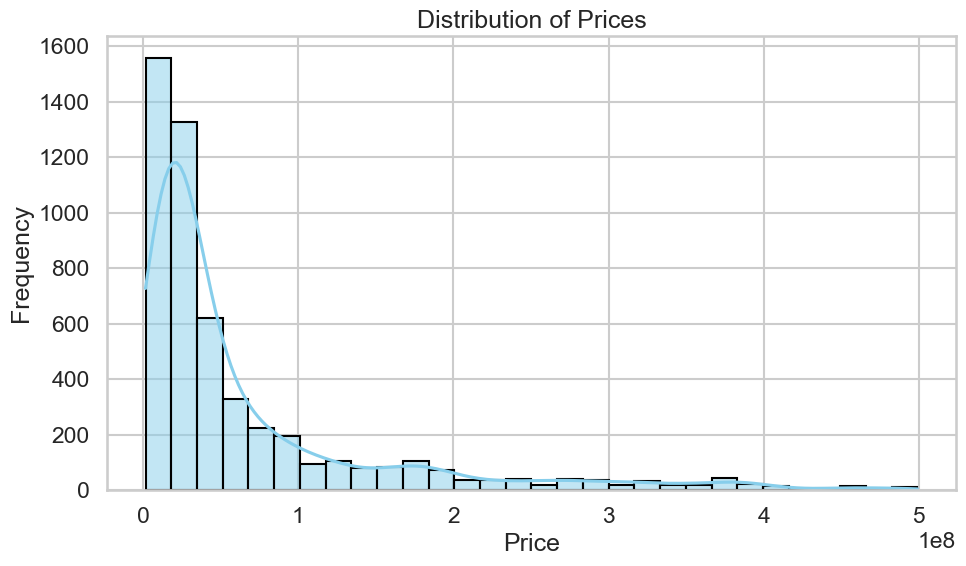

In [112]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df[df.price < 500000000], x='price', kde=True, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [113]:
df['price_per_m'] = df['price']/df['total_meters']

/var/folders/16/gvgn76k51z9908w6pgr_j60h4szdym/T/ipykernel_28749/3895675818.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_per_m'] = df['price']/df['total_meters']


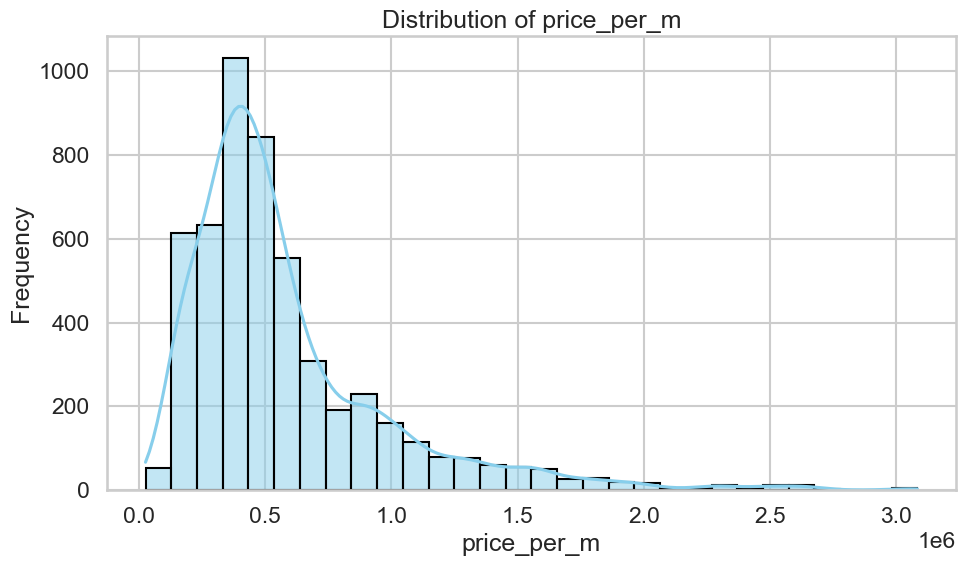

In [114]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df[df.price < 500000000], x='price_per_m', kde=True, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of price_per_m')
plt.xlabel('price_per_m')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()